# Pr&aacute;ctica 4: Sensado de señales fisiológicas

<style>
    .imagen-ajustada {
        width: 900px;
        height: 280px;
        border-radius: 20px;
    }
</style>

<img src="electro.jpg" alt="Una imagen" class="imagen-ajustada">

Esta pr&aacute;ctica tuvo como objetivo comprender como se siente una persona en una situaci&oacute;n de estres, en este caso se tuvo como prueba la presentacion de avance de proyecto de la materia de ciencia de datos para sensores inteligentes. Se sensaron los datos fisiologicos por medio de un sensor de frecuencia cardiaca Polar H10 mientras se explicaba el avance, tambien se grabo la exposicion y por ultimo los doctores hicieron preguntas que nos resultaran estresantes y asi tomar los datos requeridos.

## Librer&iacute;as Importadas

In [3]:
import os
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt
import re


## Manejo del dataset

En esta secci&oacute;n podemos ver que traemos los datos de cada participante para ver como son sus respectivos estados en medio de la presentaci&oacute;n.

In [4]:
path = './Fisiologico/'
list_dir = os.listdir(path=path)
fisiological_data = {}
for dir in list_dir:
    if dir.startswith("Audios"):
        continue
    file = dir.upper()
    fisiological_data[file] = pd.read_csv(path + dir +"/"+ file + ".txt", header=None, names=["RR"])

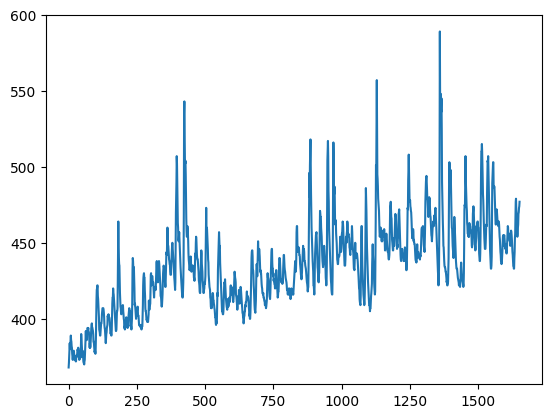

In [5]:
fisiological_data["ARIANA"]

plt.plot(fisiological_data["ARIANA"])

Al momento de ir avanzado, se pudo ver que los audios tienen acento en los nombres correspondientes, pero mejor se opto por quitarlos para evitar cualquier tipo de percance.

In [6]:
def quitar_acentos(palabra):
    palabra_normalizada = unicodedata.normalize('NFD', palabra)
    palabra_sin_acentos = ''.join(c for c in palabra_normalizada if unicodedata.category(c) != 'Mn')
    return palabra_sin_acentos

palabras_con_acentos = ["ANDRÉS", "JESÚS"]
palabras_sin_acentos = []

for palabra in palabras_con_acentos:
    palabra_sin_acento = quitar_acentos(palabra)
    palabras_sin_acentos.append(palabra_sin_acento)

print(palabras_sin_acentos)

['ANDRES', 'JESUS']


## Procesamiento de datos

Para poder comenzar con el problema, primero se tiene que segmentar los datos de forma individual, para despues tomar como analisis cada uno de ellos e ir determinando si el participantes tiene estres y en que medida.

In [7]:
def milisegundos_a_timestamp(milisegundos):
    # Convertir milisegundos a segundos
    segundos_totales = int(milisegundos // 1000)
    milisegundos_restantes = int(milisegundos % 1000)  # Convertir a entero para asegurar el formato correcto
    horas = int(segundos_totales // 3600)
    minutos = int((segundos_totales % 3600) // 60)
    segundos = int(segundos_totales % 60)
    # Formatear como HH:MM:SS.mmm donde 'mmm' son los milisegundos
    return f"{horas:02d}:{minutos:02d}:{segundos:02d}.{milisegundos_restantes:03d}"

In [8]:
for subject in fisiological_data:
    df = fisiological_data[subject]  # Para mejorar la legibilidad
    tiempoAcumulado = 0  # Reinicia para cada sujeto
    timestamps = []  # Lista para almacenar los timestamps calculados
    
    for index, row in df.iterrows():
        tiempoAcumulado += row["RR"]
        timestamp = milisegundos_a_timestamp(tiempoAcumulado)
        timestamps.append(timestamp)
    
    df["timestamp"] = timestamps  # Asignar la lista de timestamps a la columna 'timestamp' del DataFrame

In [9]:
df

,RR,timestamp
0,426,00:00:00.426
1,424,00:00:00.850
2,420,00:00:01.270
3,422,00:00:01.692
4,424,00:00:02.116
...,...,...
1147,459,00:08:00.353
1148,464,00:08:00.817
1149,472,00:08:01.289
1150,479,00:08:01.768


## An&aacute;lisis Exploratorio 

## Segmentaci&oacute;n 

## Extracci&oacute;n de Caracter&iacute;sticas

https://colab.research.google.com/drive/1HfTYZtZ38BVyIMHM21V87WkHjvl0qY3_?usp=sharing

In [10]:
import numpy as np
import pyhrv.time_domain as td
import pandas as pd
caracteristicas_hrv = [
    "nni_counter", "nni_mean", "nni_min", "nni_max",
    "hr_mean", "hr_min", "hr_max", "hr_std",
    "nni_diff_mean", "nni_diff_min", "nni_diff_max",
    "sdnn", "sdnn_index", "sdann", "rmssd", "sdsd",
    "nn50", "pnn50", "nn20", "pnn20",
    "nni_histogram", "tinn_n", "tinn_m", "tinn", "tri_index"
]
def extraer_caracteristicas_hrv_tiempo_a_df(rr_intervals):
    # Asegúrate de que los intervalos RR estén en formato numpy array
    rr_intervals = np.array(rr_intervals)
    
    # Calcula características del dominio del tiempo
    time_domain_results = td.time_domain(nni=rr_intervals, plot=False)
    
    # Extraemos el diccionario de resultados
    resultados = pd.DataFrame([time_domain_results], columns=caracteristicas_hrv)  # [1] contiene el diccionario con los resultados
    
    return resultados

# Ejemplo de uso
rr_intervals = [800, 810, 790, 820, 800, 770, 760, 790, 810, 800]  # Sustituye esto por tus datos reales de intervalos RR
df_caracteristicas_hrv_tiempo = extraer_caracteristicas_hrv_tiempo_a_df(rr_intervals)
df_caracteristicas_hrv_tiempo

c:\Users\ages0\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyhrv\utils.py:367: UserWarning: Signal duration is to short for segmentation into 300000s. Input data will be returned.
  warnings.warn("Signal duration is to short for segmentation into %is. Input data will be returned." % duration)
c:\Users\ages0\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyhrv\time_domain.py:303: UserWarning: Signal duration too short for SDANN computation.
  warnings.warn("Signal duration too short for SDANN computation.")
c:\Users\ages0\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyhrv\time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '


,nni_counter,nni_mean,nni_min,nni_max,hr_mean,hr_min,hr_max,hr_std,nni_diff_mean,nni_diff_min,...,sdsd,nn50,pnn50,nn20,pnn20,nni_histogram,tinn_n,tinn_m,tinn,tri_index
0,10,795.0,760.0,820.0,75.508706,73.170732,78.947368,1.776261,20.0,10,...,8.660254,0,0.0,3,33.333333,None,781.25,812.5,31.25,3.333333


### Info Gain

## Modelos a Evaluar

## Entrenando el Mejor modelo

## Validaci&oacute;n 

## Conclusiones